In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rnd
from tqdm import tqdm_notebook #gives a progress bar

# visualizatoin
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
plt.style.use('ggplot')


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')

categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")


# change date to datetime format
train['date'] = pd.to_datetime(train['date'], format = "%d.%m.%Y")

# **INITIAL INSIGHTS**

In [2]:
print('train', train.shape)
print('test', test.shape)

train (2935849, 6)
test (214200, 3)


Looks like there is a greater amount of training data. This could make it easier or it could mean overfitting. There are also 6 columns for the training data and only three for the test data. We need to get a look at both datasets to see what is going on, and which data is used for predictions. We can see this by looking at which columns are in both datasets.

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [4]:
test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


Test dataset contains shop_id and item_id and we are trying to predict item_cnt_day

In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [7]:
# Find any missing values (NaN)
train.isnull().sum(axis=0).head(10)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### Functions


In [8]:
def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);

# Don't really know about this one
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True) #subset is list where you have to put all column for duplicate check
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)

{dtype('int64'), dtype('float64'), dtype('<M8[ns]')}


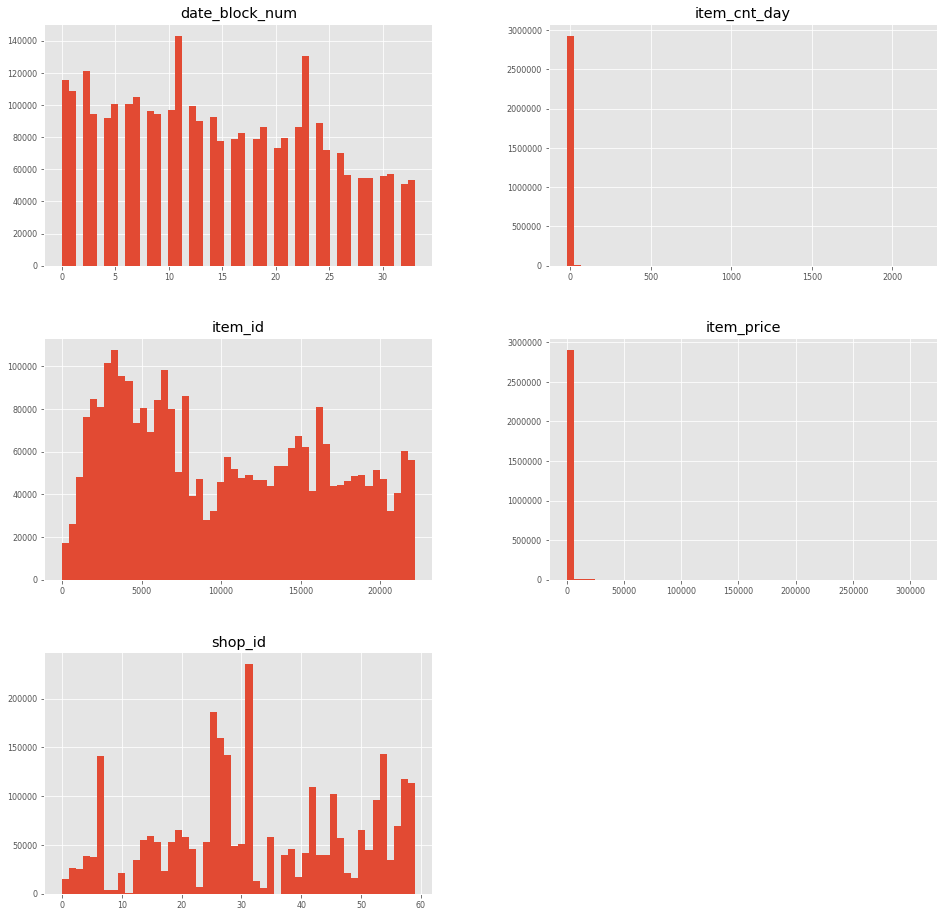

In [9]:
# Get initial graphs by calling graph_insight function
# Gives us the total count 
graph_insight(train)

## Data Cleaning

**This is where we will fill any missing values, check for duplicate and constant features**

**We will also combine the data to allow any changes to apply to all datasets**

In [10]:
# Concatinate the data
traintest = pd.concat([train, test], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


#### Remove Constant Features

In [11]:
# Constant Features
#Find out how many unique values are in each column
# If a column has only one unique feature or value then we can drop it because it is a constant feature
# dropna = False ; makes nunique treat NaN as distinct value
feats_count = train.nunique(dropna=False)
feats_count.sort_values()

date_block_num       34
shop_id              60
item_cnt_day        198
date               1034
item_price        19993
item_id           21807
dtype: int64

No constant features. That means we can keep all of the columns for now

In [12]:
# Drop Constant Features
#constant_features = feats_count.loc[feats_count==1].index().tolist()
#print(constant_features)

# drop from train & test set because if not used to train, then shouldn't be used in test set
#traintest.drop(constant_features, axis=1, inplace=True) 

#### Remove Duplicated Features

In [13]:
# fill missing values with something we can find later
traintest.fillna('NaN', inplace=True)

Now let's encode each value

In [14]:
# create new dataset with encoded train features
train_enc = pd.DataFrame(index = train.index)

for col in tqdm_notebook(train.columns):
    train_enc[col] = train[col].factorize()[0]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [15]:
# Iterate over all of the values and create a new array with duplicated columns
dup_cols = {}

for i, c1 in enumerate(tqdm_notebook(train_enc.columns)):
    for c2 in train_enc.columns[i + 1:]:
        if c2 not in dup_cols and np.all(train_enc[c1] == train_enc[c2]):
            dup_cols[c2] = c1
            
# Show duplicated columns (feautures)
dup_cols

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


{}

In [16]:
# Drop duplicate features
#traintest.drop(dup_cols.keys(), axis=1, inplace=True)

No duplicate columns in this dataset. 

### Other Data Sets


#### 1. **Viewing Datasets other than Train and Test**

In [17]:
# Datasets: items, shops, categories
print('items:', items.shape)
print('shops:',shops.shape)
print('categories:', categories.shape)

items: (22170, 3)
shops: (60, 2)
categories: (84, 2)


In [18]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


We need to find out if this dataset can be joined to our dataset. To do this we need to determine if the item_id is the same. If it is then we want to join the datasets and replace the item_id in train with this one. 

In [19]:
items.item_id.value_counts()


2047     1
2724     1
4759     1
19100    1
17053    1
        ..
19779    1
5448     1
7497     1
1354     1
0        1
Name: item_id, Length: 22170, dtype: int64

In [20]:
print('items:', items.item_id.agg([min, max]))
print('train:', train.item_id.agg([min, max]))

items: min        0
max    22169
Name: item_id, dtype: int64
train: min        0
max    22169
Name: item_id, dtype: int64


So, they are the same items. This means that the items dataset just provides a description of each item that is listed in the training set. We need to combine them so that all the data in the training set will have the descriptions. 

We can likley assume the same for shops and categories datasets.

In [21]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [22]:
print('shops:', shops.shop_id.agg([min, max]))
print('train:', train.shop_id.agg([min, max]))

shops: min     0
max    59
Name: shop_id, dtype: int64
train: min     0
max    59
Name: shop_id, dtype: int64


In [23]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [24]:
print('categories:', categories.item_category_id.agg([min, max]))
print('train:', train.item_cnt_day.agg([min, max]))

categories: min     0
max    83
Name: item_category_id, dtype: int64
train: min     -22.0
max    2169.0
Name: item_cnt_day, dtype: float64


#### 2. **Join Datasets**

In [25]:
new_train = train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [26]:
# Understanding Data in new_train dataset
print("Description of training set")
print("Shape: \t\t\t", new_train.shape)
print("#NaNs: \t\t\t", new_train.isna().sum().sum()) # No NaN
print("#Shops: \t\t", new_train.shop_id.nunique())
print("#Item Categories: \t", new_train.item_category_id.nunique())
print("#Items: \t\t", new_train.item_id.nunique())
print("#Months: \t\t", new_train.date_block_num.nunique())
print("Date range from: \t", new_train.date.min(), " to ", new_train.date.max())
print("Price range from: \t", new_train.item_price.min(), " to ", new_train.item_price.max())
print("Units Sold range from: \t", new_train.item_cnt_day.min(), " to ", new_train.item_cnt_day.max())

Description of training set
Shape: 			 (2935849, 10)
#NaNs: 			 0
#Shops: 		 60
#Item Categories: 	 84
#Items: 		 21807
#Months: 		 34
Date range from: 	 2013-01-01 00:00:00  to  2015-10-31 00:00:00
Price range from: 	 -1.0  to  307980.0
Units Sold range from: 	 -22.0  to  2169.0


In [27]:
new_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


# **UNIVARIATE DATA ANALYSIS**

#### ITEM COUNT


In [28]:
new_train.item_cnt_day.value_counts()

1.0      2629372
2.0       194201
3.0        47350
4.0        19685
5.0        10474
          ...   
179.0          1
187.0          1
194.0          1
195.0          1
508.0          1
Name: item_cnt_day, Length: 198, dtype: int64

In [29]:
new_train.item_cnt_day.agg([min, max])


min     -22.0
max    2169.0
Name: item_cnt_day, dtype: float64

It appears there are some negative values in the item count per day. This means that there a records of selling negative items. These will likely have to be dropped. The largest amount of items sold in one day is 2,169. Way off from the standard. 

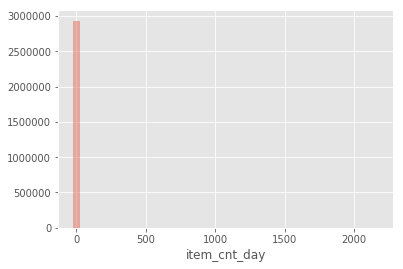

In [30]:
sns.distplot(a=new_train['item_cnt_day'], kde=False)

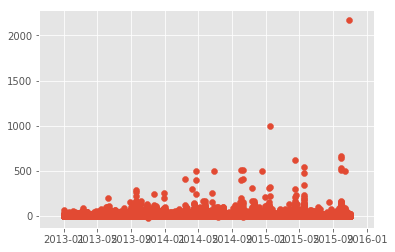

In [31]:
plt.scatter(new_train['date'],new_train['item_cnt_day'])

We can see from this scatter plot there is at least one large outlier in amount sold per day. Most are around 1 item per day, but there is one day with over 2000 items sold, and another with over 1000. 

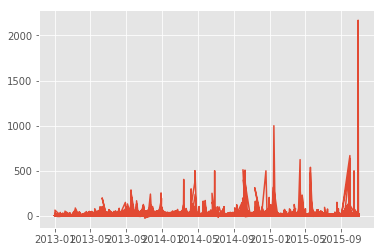

In [32]:
# since we are trying to find the number of items sold in a month
# we will look item_cnt_day first
plt.plot(new_train['date'], new_train['item_cnt_day'])

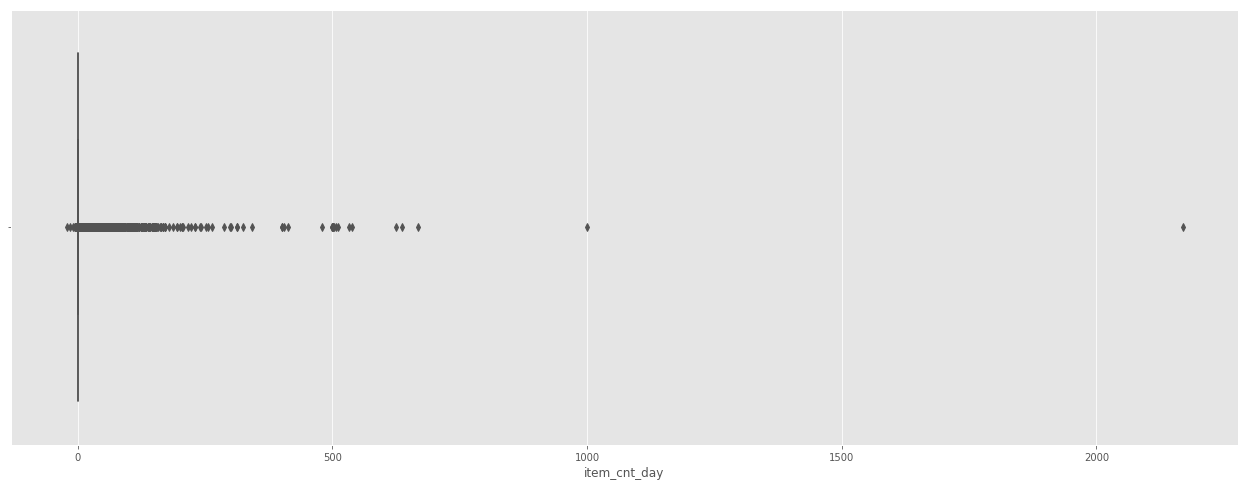

In [33]:
# This plot lets us see the distribution
plt.subplots(figsize=(22, 8))
sns.boxplot(new_train['item_cnt_day'])
plt.show()

**Summary**

There are 21,804 unique items in this data set. The median number of items sold per day is 1. Over 95% of the days consist of just one items sold. However there are a few outliers in the data. There is one day with over 2000 items sold and a few others with hundreds of items sold. So the most common scenario is one item. It also looks like more items were sold in the later years

#### ITEM PRICE

In [34]:
# Average item price
avg_item_price = new_train[['item_id', 'item_price']].groupby('item_id')['item_price'].mean()

avg_item_price = avg_item_price.reset_index()
avg_item_price = avg_item_price.rename(columns={'item_price':'avg_item_price'})

avg_item_price.head()

,item_id,avg_item_price
0,0,58.0
1,1,4490.0
2,2,58.0
3,3,79.0
4,4,58.0


In [35]:
avg_item_price.describe()

,item_id,avg_item_price
count,21807.000000,21807.000000
mean,11098.699271,823.890413
std,6397.059362,2784.195667
min,0.000000,4.914856
25%,5551.500000,186.541323
50%,11105.000000,322.363636
75%,16647.500000,850.000000
max,22169.000000,307980.000000


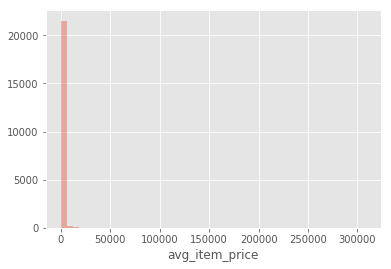

In [36]:
sns.distplot(a=avg_item_price['avg_item_price'], kde=False)

**Summary**

The price range per item is from 0.07 to 307,980. The average item price for the average for each item is 822.69. 

#### ITEM CATEGORIES

In [37]:
# Find out how many item categories there are
print("#Item Categories: \t", new_train.item_category_id.nunique())

#Item Categories: 	 84


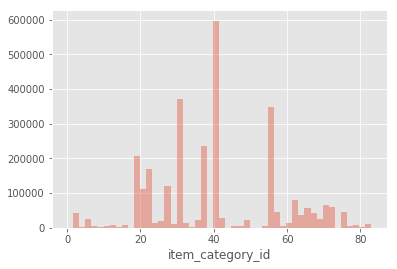

In [38]:
# Find distribution of categories
sns.distplot(a=new_train['item_category_id'], kde=False)

In [39]:
new_train.item_category_id.value_counts()

40    564652
30    351591
55    339585
19    208219
37    192674
       ...  
0          3
50         2
1          2
10         1
51         1
Name: item_category_id, Length: 84, dtype: int64

**Summary**

There are 84 different item categories. The distribution is pretty normal, with most of the items being in category 40 (563938) and the least amount being in categories 10 and 51 (1). Some of the other common categories were 30, 55, 19, 37, 22, 20, etc. 

#### SHOPS

In [40]:
# Total number of shop id's
print("#Shops: \t", new_train.shop_id.nunique())

#Shops: 	 60


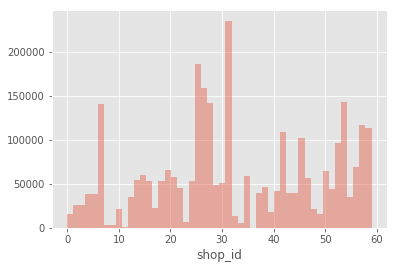

In [41]:
sns.distplot(a=new_train['shop_id'], kde=False)

**Summary**

There are 60 different shops included in the dataset. The distribution is pretty normal and not as concentrated as others. It appears the shops between 25 and 35 appear the most times. And shops between 50 and 60 appear the second most. Now we just have an idea of how many shops are included in dataset.

## DATA PREPROCESSING

### 1. Replace NaN

Above we filled in all the missing values with "NaN". In this dataset there were no missing values so this won't really apply. Normally, if there are missing values then we will have to choose to replace them with numbers if they are numerical or strings if they are categorical. 

Usually the numbers are chosen by taking the mean of that feature or the most common, or doing them by hand if the dataset is small enough. We can also use models to predict what missing value will be and fill them that way. Same goes for categoricals. 

In [42]:
# Look at notes to see ways to fill missing values
# Not needed in this competition

### 2. Drop Outliers

In [43]:
# Determine the max and min prices selling for
new_train.item_price.agg([min, max])

min        -1.0
max    307980.0
Name: item_price, dtype: float64

In [44]:
# we are going to drop any days where the price is not positive
new_train = new_train.loc[new_train['item_price'] > 0]
new_train.shape


(2935848, 10)

   We know from our vizualizations that over 99% of the days have sales counts of 20 or less, so we will drop any outliers over that.

In [45]:
# Because there is negative data and outliers we are going to drop
# I want to drop these outliers before groupin them because I do not want to have to drop entire months
# SO I am going to drop any negative sales count days and any over 20

new_train = new_train.loc[new_train['item_cnt_day'] >= 0]
new_train = new_train.loc[new_train['item_cnt_day'] <= 20]
new_train.shape


(2925078, 10)

In [46]:
new_train.item_cnt_day.agg([min, max])

min     1.0
max    20.0
Name: item_cnt_day, dtype: float64

In [47]:
new_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
5,2013-01-10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,"Москва ТРК ""Атриум""",Музыка - Музыкальное видео


### 3. Map Data

We are going to wait to map it until the feature engineering, but this process can be used in exploratory data analysis as well. 

### 4. Format Data for Submission

#### Drop Data that is not in Test

In [48]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
t_train = new_train[new_train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
t_train = t_train[t_train['item_id'].isin(test_item_ids)]

In [49]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', t_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1219335


#### Aggregate Daily Data into Months and Fill Missing Months

We are formatting the data by combining all of the item and shop sales in each month. The competition calls for monthly data and the train is daily data. So we add together the sales of each item/shop pair per month.

For each item and shop it only includes the month when items were sold. If that item does not have other monthly rows then we can conclude that it did not sell then. So we need to fill in these missing months with zero.

This will mimic the real data by filling in the missing months with zero. 

In [50]:
# Use only the useful features
# Drop the string features
t_train = t_train[['date', 'date_block_num', 'shop_id', 
                    'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [51]:
t_train.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,37,22154,999.0,1.0
10,2013-01-03,0,25,55,2574,399.0,2.0
11,2013-01-05,0,25,55,2574,399.0,1.0
12,2013-01-07,0,25,55,2574,399.0,1.0
13,2013-01-08,0,25,55,2574,399.0,2.0


In [52]:
t_train = t_train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
t_train = t_train.agg({'item_price':['sum'], 'item_cnt_day':['sum']})
# Rename features.
t_train.columns = ['date_block_num', 'shop_id', 'item_category_id', 
                         'item_id', 'item_price', 'item_cnt_month']

In [53]:
t_train.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,0,2,2,5572,10730.0,9.0
1,0,2,2,5643,2390.0,1.0
2,0,2,5,5583,1188.3,2.0
3,0,2,6,7893,5970.0,3.0
4,0,2,6,7894,1490.0,1.0


In [54]:
t_train.shape

(599896, 6)

In [55]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
# From notebook by Dimitre
shop_ids = t_train['shop_id'].unique()
item_ids = t_train['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [56]:
# Merge the train set with the complete set (missing records will be filled with 0).
new_train = pd.merge(empty_df, t_train, on=['date_block_num','shop_id','item_id'], how='left')
new_train.fillna(0, inplace=True)

In [57]:
new_train.shape

(6734448, 6)

In [58]:
new_train.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
0,0,2,5572,2.0,10730.0,9.0
1,0,2,5643,2.0,2390.0,1.0
2,0,2,5583,5.0,1188.3,2.0
3,0,2,7893,6.0,5970.0,3.0
4,0,2,7894,6.0,1490.0,1.0


# **BIVARIATE DATA ANALYSIS**

## 1. MONTHLY DATA

**Group the Data**

In [59]:
# group data together in months
# We will group by the data_block_num
# make new dataset
train_monthly = new_train[['date_block_num', 'item_cnt_month']].groupby('date_block_num')['item_cnt_month'].sum()

train_monthly = train_monthly.reset_index()
train_monthly = train_monthly.rename(columns={'date_block_num':'month','item_cnt_month':'items_sold' })
train_monthly.head()

,month,items_sold
0,0,20622.0
1,1,22000.0
2,2,30895.0
3,3,20671.0
4,4,22377.0


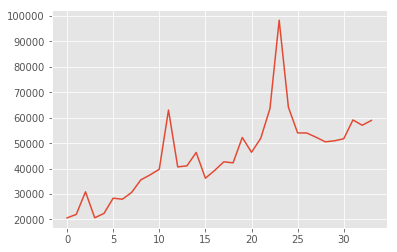

In [60]:
# We grouped the data by month above
# We are plotting the items sold per month
plt.plot(train_monthly.items_sold)

Looks like items sold per month started out at aroun 130,000. It has been going down steadily to under 90,000 in the last months. Except for two times where it jumped up very high. In months 10 and 11 it jumps up to over 180,000 items sold. And it month 23(?) it jumped up to over 160,000 items sold. 

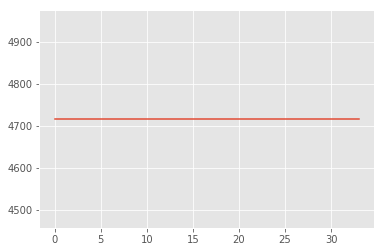

In [61]:
# Number of unique items sold each month
train_month = new_train[['date_block_num', 'item_id']].groupby(by='date_block_num', as_index=False).nunique()
plt.plot(train_month.item_id)

The unique items sold per month also went down. This could be some sort of error or leakage in the data we might have to test. But it does show there is a correlation between items sold and number of unique items sold. 

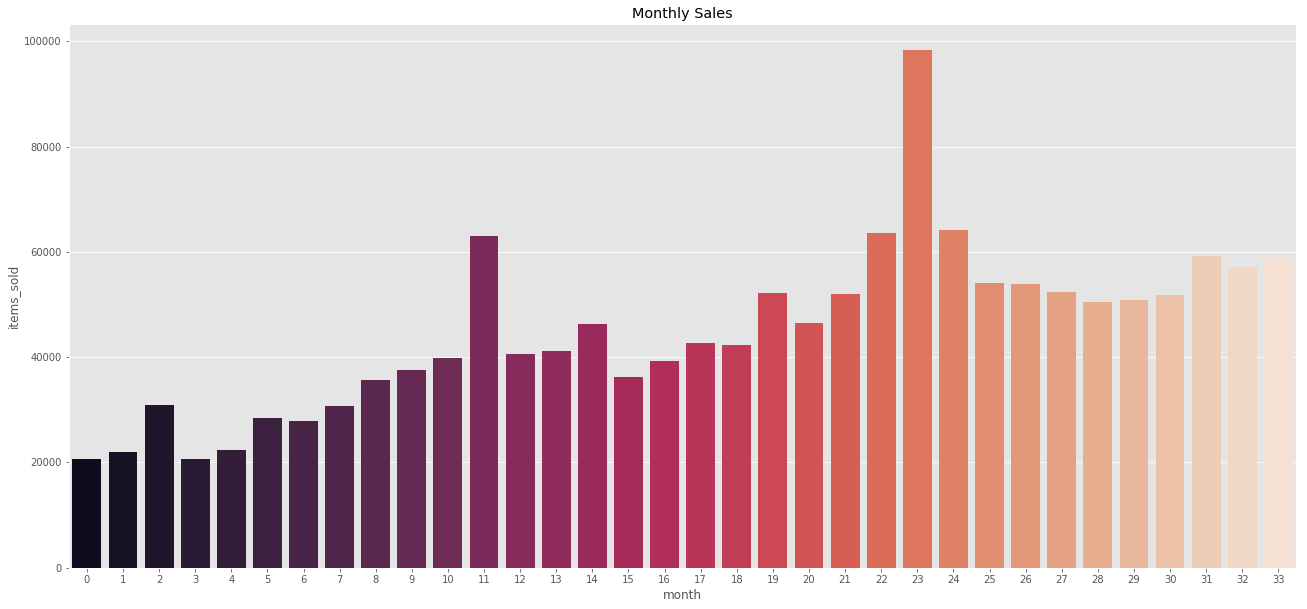

In [62]:
f, axes = plt.subplots(figsize=(22, 10))

sns.barplot(x="month", y="items_sold", data=train_monthly, palette="rocket").set_title("Monthly Sales")
plt.show()

**Summary:**
It looks like there is a spike in sales right around the end of every year in December. The obvious explanation would be Christmas, bonus checks, end of year spending, etc. The charts show that the sales are steadily decreasing over the three years as well. This could just be lower sales, or maybe some kind of data leakage. 

### Test and Train Data Overlap


We want to find out how many of the items in the test data are also in the train data

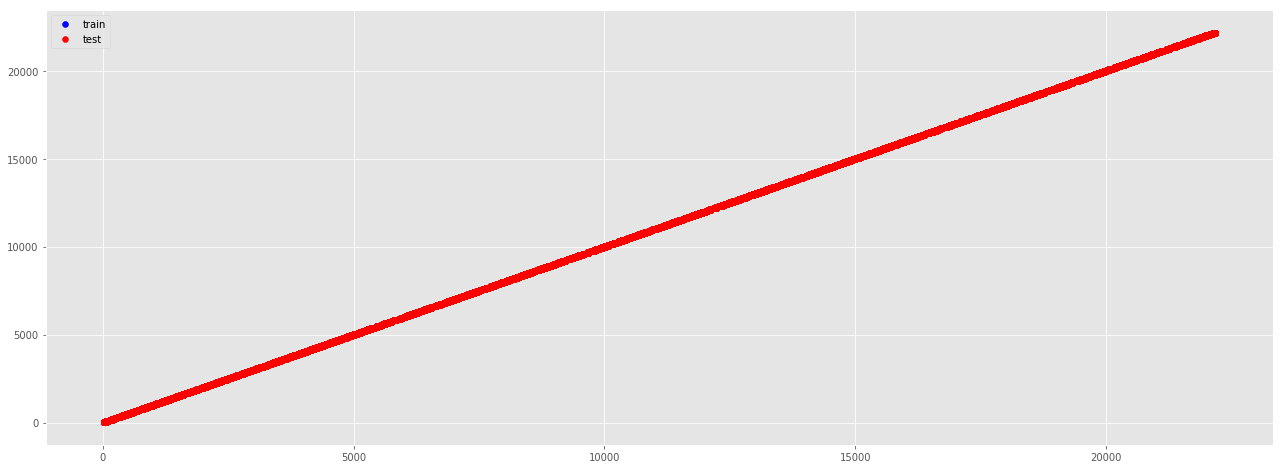

In [63]:

plt.subplots(figsize=(22, 8))
plt.scatter(new_train['item_id'],new_train['item_id'], c='b', label='train')
plt.scatter(test['item_id'], test['item_id'], c='r', label='test')
plt.legend(loc='upper left')
plt.show()

Looks like the train and test item_id's are all between the same max and min. This tells us they mostly overlap, but that there may be some items in test that are not in train. The trouble with these are that I might not be able to generate and item price or category for them. 

### Correlation

In [64]:
new_train.corr()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
date_block_num,1.000000e+00,-1.397437e-19,5.674063e-21,0.102082,0.034491,0.027439
shop_id,-1.397437e-19,1.000000e+00,-4.896589e-17,0.009452,-0.000803,0.002562
item_id,5.674063e-21,-4.896589e-17,1.000000e+00,-0.001450,-0.044505,-0.016785
item_category_id,1.020824e-01,9.451848e-03,-1.449672e-03,1.000000,0.180318,0.299112
item_price,3.449080e-02,-8.028251e-04,-4.450532e-02,0.180318,1.000000,0.308262
item_cnt_month,2.743930e-02,2.562481e-03,-1.678458e-02,0.299112,0.308262,1.000000


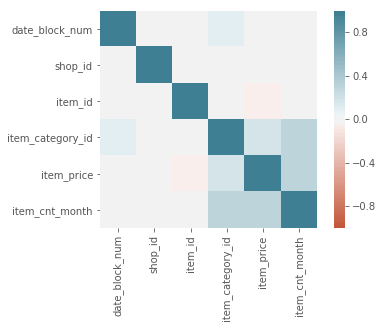

In [65]:
# Correltation matrix heatmap
corr = new_train.corr()

sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200), square=True)

Does not appear to be any strong correlations between any feature and the number of items sold per month. The strongest correlations are between item price and item_cnt_month and item category id and item_cnt_mnth. They are both around 0.3 correlation.  


#### Which Shop Sells More?

In [66]:
# Total items sold per shop
items_per_shop = new_train[['shop_id', 'item_cnt_month']].groupby('shop_id')['item_cnt_month'].sum()

items_per_shop = items_per_shop.reset_index()
items_per_shop = items_per_shop.rename(columns={'shop_id':'shop','item_cnt_month':'items_sold' })
items_per_shop.head()

,shop,items_sold
0,2,18740.0
1,3,16601.0
2,4,23837.0
3,5,24280.0
4,6,49425.0


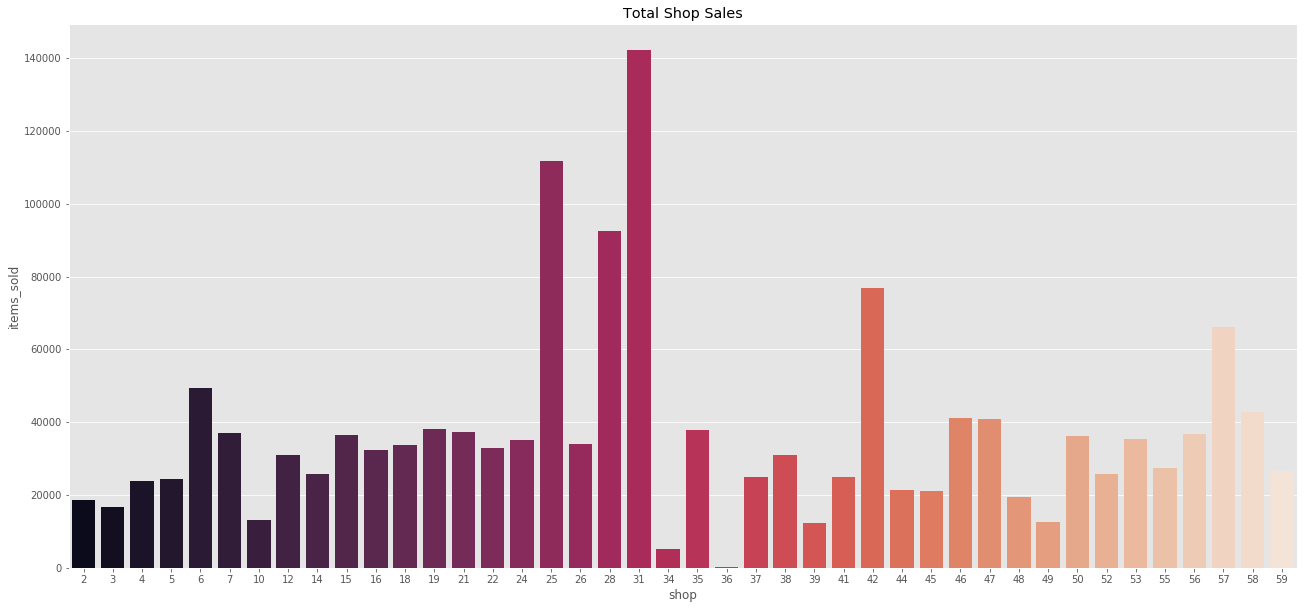

In [67]:
f, axes = plt.subplots(figsize=(22, 10))
# Separates shops by number of sales (sum)
sns.barplot(x="shop", y="items_sold", data=items_per_shop, palette="rocket").set_title("Total Shop Sales")
plt.show()

This chart shows the total sales for each shop. 

#### Relationship Between Price/Items Sold per Month

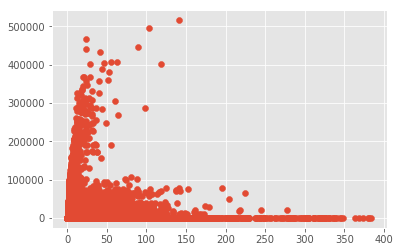

In [68]:
# Scatter plot showing sales and price
plt.scatter(new_train.item_cnt_month, new_train.item_price)

We are going to drop any item that is priced over 350,000.

In [69]:
# drop outliers in item_price
new_train = new_train.loc[new_train['item_price'] <= 350000]
new_train = new_train.loc[new_train['item_cnt_month'] <= 200]
new_train.item_price.describe()

count    6.734302e+06
mean     1.851254e+02
std      2.047041e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.468700e+05
Name: item_price, dtype: float64

In [70]:
new_train.shape

(6734302, 6)

#### Total Sales by Month (Name)

It looks like the amount of items sold peaks in November and December of each year. I want to see if there are patterns based on the months. To find this we are going to need to create a new feature with the months encoded (using date_block_num).

In [71]:
# Encoding Months
new_train['Month'] = new_train['date_block_num'].map({0: 'Jan',
                                                      1: 'Feb',
                                                      2: 'March',
                                                      3: 'April',
                                                      4: 'May',
                                                      5: 'June',
                                                      6: 'July',
                                                      7: 'Aug',
                                                      8: 'Sept',
                                                      9: 'Oct',
                                                      10: 'Nov',
                                                      11: 'Dec',
                                                      12: 'Jan',
                                                      13: 'Feb',
                                                      14: 'March',
                                                      15: 'April',
                                                      16: 'May',
                                                      17: 'June',
                                                      18: 'July',
                                                      19: 'Aug',
                                                      20: 'Sept',
                                                      21: 'Oct',
                                                      22: 'Nov',
                                                      23: 'Dec', 
                                                      24: 'Jan',
                                                      25: 'Feb',
                                                      26: 'March',
                                                      27: 'April',
                                                      28: 'May',
                                                      29: 'June',
                                                      30: 'July',
                                                      31: 'Aug',
                                                      32: 'Sept',
                                                      33: 'Oct'
                                                      })

In [72]:
# This allows us to sort the data by month
new_train['m_num'] = new_train['Month'].map({'Jan': 1,
                                                 'Feb': 2,
                                                 'March': 3,
                                                 'April': 4,
                                                 'May': 5,
                                                 'June': 6,
                                                 'July': 7,
                                                 'Aug': 8,
                                                 'Sept': 9,
                                                 'Oct': 10,
                                                 'Nov': 11,
                                                 'Dec': 12
                                                    })

In [73]:
new_train.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,Month,m_num
0,0,2,5572,2.0,10730.0,9.0,Jan,1
1,0,2,5643,2.0,2390.0,1.0,Jan,1
2,0,2,5583,5.0,1188.3,2.0,Jan,1
3,0,2,7893,6.0,5970.0,3.0,Jan,1
4,0,2,7894,6.0,1490.0,1.0,Jan,1


In [74]:
# Sales by Month
monthly_sales = new_train[['Month', 'item_cnt_month']].groupby('Month')['item_cnt_month'].sum()

monthly_sales.head(12)

Month
April    107075.0
Aug      137896.0
Dec      156811.0
Feb      116443.0
Jan      123664.0
July     117750.0
June     117844.0
March    130398.0
May      109178.0
Nov      101328.0
Oct      144325.0
Sept     135107.0
Name: item_cnt_month, dtype: float64

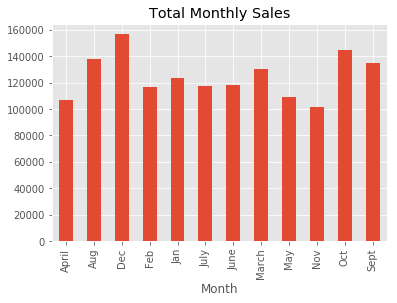

In [75]:
monthly_sales.plot(kind='bar', title='Total Monthly Sales')

December and January have the highest number of items sold. This is because of the peaks and because the number of items sold per day is decreasing over the entire time horizon. Because of that months like November have low numbers of items sold. It is likely that the next month will be a low number, but maybe near the end it picks up more than the previous two months. Need to look at graph of items sold for each month in year. 

### DATA LEAKAGE 

Determine if the Data is Shuffled

Look for any time series leakage

## NEW DATASET

We make a new csv dataset from train_new so we can use it in other notbooks.

In [76]:
# Change to csv
new_train.to_csv('Training_Data.csv', index=False)